In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy import stats

from jax import jit, random, vmap, grad
from jax import numpy as jnp
from jax.experimental import optimizers

from neural_tangents import stax
from neural_tangents.predict import gradient_descent_mse_ensemble

from tqdm import trange

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def target_fn(x):
    return np.sin(x)


def get_kernel_fn_1():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(1, W_std=1),
    )
    return jit(kernel_fn, static_argnums=(2,))


def get_kernel_fn_2():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(1, W_std=1, b_std=0),
    )
    return jit(kernel_fn, static_argnums=(2,))


def partial(func, *args, **kwargs):
    return lambda key: func(key, *args, **kwargs)


def sample_network(key, alpha, beta, x_test):
    gamma_pure = random.gamma(key, a=alpha)
    gamma_rho = gamma_pure / beta
    invgamma = 1 / gamma_rho  # invgamma ~ invgamma(a = nu_q/2, scale = rho_q/2)
    sigma = jnp.sqrt(invgamma)

    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(1, W_std=sigma, b_std=0)
    )

    _, params = init_fn(key, (-1, 1))
    samples = apply_fn(params, x_test)

    return samples


def last_train_network(key, alpha, beta, x_train, y_train, x_test,
                       opt_init, opt_update, get_params, train_steps):
    gamma_pure = random.gamma(key, a=alpha)
    gamma_rho = gamma_pure / beta
    invgamma = 1 / gamma_rho  # invgamma ~ invgamma(a = nu_q/2, scale = rho_q/2)
    sigma = jnp.sqrt(invgamma)

    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(1, W_std=sigma, b_std=0)
    )

    _, params = init_fn(key, (-1, 1))
    opt_state = opt_init(params)

    loss = jit(lambda params, x, y: 0.5 * jnp.mean((apply_fn(params, x) - y) ** 2))
    grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

    for i in trange(train_steps):
        grad_loss_whole = grad_loss(opt_state, x_train, y_train)

        grad_loss_front = [tuple([e * 0. for e in x]) for x in grad_loss_whole[:-1]]
        grad_loss_whole = grad_loss_front + [grad_loss_whole[-1]]

        opt_state = opt_update(i, grad_loss_whole, opt_state)

    params = get_params(opt_state)
    samples = apply_fn(params, x_test)

    return samples


def full_train_network(key, alpha, beta, x_train, y_train, x_test,
                       opt_init, opt_update, get_params, train_steps):
    gamma_pure = random.gamma(key, a=alpha)
    gamma_rho = gamma_pure / beta
    invgamma = 1 / gamma_rho  # invgamma ~ invgamma(a = nu_q/2, scale = rho_q/2)
    sigma = jnp.sqrt(invgamma)

    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(512, W_std=8, b_std=0.05), stax.Erf(),
        stax.Dense(1, W_std=sigma, b_std=0)
    )

    _, params = init_fn(key, (-1, 1))
    opt_state = opt_init(params)

    loss = jit(lambda params, x, y: 0.5 * jnp.mean((apply_fn(params, x) - y) ** 2))
    grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

    for i in trange(train_steps):
        grad_loss_whole = grad_loss(opt_state, x_train, y_train)
        opt_state = opt_update(i, grad_loss_whole, opt_state)

    params = get_params(opt_state)
    samples = apply_fn(params, x_test)

    return samples

In [27]:
def draw_corr(
    part,
    train_num = 5,
    test_num = 40,
    alpha = 1.,
    beta = 1.,
    seed = 10,
    noise_scale = 0.1,
    learning_rate = 1e-3,
    ensemble_size = 1000,
    train_steps = 10000,
):

    key = random.PRNGKey(seed)
    key, x_key, y_key = random.split(key, 3)

    start, stop = (-np.pi, +np.pi)

    # Dataset
    x_train = random.uniform(x_key, minval=start, maxval=stop, shape=(train_num, 1))
    y_train = target_fn(x_train) + noise_scale * random.normal(y_key, shape=(train_num, 1))

    x_test = jnp.linspace(start, stop, num=test_num)[:, None]
    y_test = target_fn(x_test)

    x = jnp.concatenate([x_train, x_test], axis = 0)

    # Kernel
    if part == "initial":
        nu = 2 * alpha
        mu = jnp.zeros(test_num)
        kernel_fn_2 = get_kernel_fn_2()
        cov_2 = kernel_fn_2(x_test, x_test, get="nngp")
        cov = beta / alpha * cov_2
    elif part == "last":
        kernel_fn_1 = get_kernel_fn_1()
        predict_fn_1 = gradient_descent_mse_ensemble(kernel_fn_1, x_train, y_train, diag_reg=1e-4)
        mean_1, cov_1 = predict_fn_1(x_test=x_test, get="nngp", compute_cov=True)

        nu = 2 * alpha
        mu = mean_1.flatten()
        cov = beta / alpha * cov_1
    elif part == "full":
        kernel_fn_1 = get_kernel_fn_1()
        predict_fn_1 = gradient_descent_mse_ensemble(kernel_fn_1, x_train, y_train, diag_reg=1e-4)
        mean_1, cov_1 = predict_fn_1(x_test=x_test, get="ntk", compute_cov=True)

        nu = 2 * alpha
        mu = mean_1.flatten()
        cov = beta / alpha * cov_1

    std = jnp.sqrt(jnp.diag(cov))

    ensemble_key = random.split(key, ensemble_size)

    if part == "initial":
        network_fn = partial(sample_network, alpha, beta, x_test)
    elif part == "last":
        opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
        opt_update = jit(opt_update)

        network_fn = partial(
            last_train_network, alpha, beta, x_train, y_train, x_test,
            opt_init, opt_update, get_params, train_steps,
        )
    elif part == "full":
        opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
        opt_update = jit(opt_update)

        network_fn = partial(
            full_train_network, alpha, beta, x_train, y_train, x_test,
            opt_init, opt_update, get_params, train_steps,
        )

    samples = vmap(network_fn)(ensemble_key)
    samples = np.squeeze(samples, axis=2).T

    # np.save(sample_output, (samples, nu, mu, std))
    # print("Save samples to '{}'".format(sample_output))

    # Figure
    def drawer(ax, idx):
        u = np.linspace(-10, 10, 100)
        student_t = stats.t.pdf(u, nu, loc=mu[idx], scale=std[idx])
        # ax.set_xlim(-10, 10)
        sns.distplot(a=samples[idx], ax=ax, label="Sampled")
        ax.plot(u, student_t, label="Predicted", linewidth=3)
        ax.set_title("Initial")
        ax.set_ylabel("Probability", fontsize=12)
        # ax.yaxis.set_ticklabels([])
        ax.legend(loc="upper right")

    return drawer

In [68]:
def draw_sinx(
    train_num = 5,
    test_num = 40,
    alpha = 1.,
    beta = 1.,
    seed = 10,
    noise_scale = 0.1,
):
    # make training xs and ys
    key = random.PRNGKey(seed)
    key, x_key, y_key = random.split(key,3)

    train_xs = random.uniform(x_key, (train_num, 1), minval = -np.pi, maxval = np.pi)

    train_ys = target_fn(train_xs)
    train_ys += noise_scale * random.normal(y_key, (train_num, 1))
    #train_ys += noise_scale * random.t(y_key, 2,(train_points, 1))
    train = (train_xs, train_ys)

    # make test xs and ys
    test_xs = np.linspace(-np.pi, np.pi, test_num)
    test_xs = np.reshape(test_xs, (test_num, 1))

    test_ys = target_fn(test_xs)
    test = (test_xs, test_ys)

    whole_xs = np.concatenate([train_xs, test_xs], axis = 0)
    
    # define first model with W_std = 2
    init_fn_1, apply_fn_1, kernel_fn_1 = stax.serial(
        stax.Dense(512, W_std = 1, b_std = 0.05), stax.Erf(),
        stax.Dense(512, W_std = 1, b_std = 0.05), stax.Erf(),
        stax.Dense(512, W_std = 1, b_std = 0.05), stax.Erf(),
        stax.Dense(1, W_std = 1)
    )

    apply_fn_1 = jit(apply_fn_1)
    kernel_fn_1 = jit(kernel_fn_1, static_argnums = (2,))

    predict_fn_1 = gradient_descent_mse_ensemble(kernel_fn_1, train_xs, train_ys, diag_reg = 1e-4)
    nngp_mean_1, nngp_covariance_1 = predict_fn_1(x_test = test_xs, get ='nngp', compute_cov = True)

    nngp_mean_1 = nngp_mean_1.reshape(-1)
    nngp_std_1 = np.sqrt(np.diag(nngp_covariance_1))
    
    kernel_tr_tr = kernel_fn_1(train_xs, train_xs, 'nngp')
    nu = 2*alpha + train_num
    nntp_mean = nngp_mean_1
    d_1 = nu + np.matmul(train_ys.T, np.matmul(np.linalg.inv(kernel_tr_tr+1e-4*np.eye(train_num)),train_ys))
    p_1 = nu + train_num
    nntp_kernel = beta / alpha * d_1/p_1*nngp_covariance_1
    nntp_kernel_sqrt = np.sqrt(np.diag(nntp_kernel))
    
    def drawer(ax0, ax1):
        ax0.scatter(train_xs, train_ys, color ='r')
        ax0.plot(test_xs, test_ys, 'k--', linewidth = 2, label="$y = \sin x$")
        ax0.plot(test_xs, nngp_mean_1, 'g', linewidth = 2, label="Gaussian")
        ax0.fill_between(np.reshape(test_xs,(-1)), nngp_mean_1 - 2*nngp_std_1, nngp_mean_1 + 2*nngp_std_1, color = 'g', alpha = 0.1)
        ax0.legend(loc="upper left")

        ax1.scatter(train_xs, train_ys, color ='r')
        ax1.plot(test_xs, test_ys, 'k--', linewidth = 2, label="$y = \sin x$")
        ax1.plot(test_xs, nntp_mean, 'g', linewidth = 2, label="Student's $t$")
        ax1.fill_between(np.reshape(test_xs,(-1)), nntp_mean - 2.*nntp_kernel_sqrt, nntp_mean + 2.*nntp_kernel_sqrt, color = 'g', alpha = 0.1)
        ax1.legend(loc="upper left")
    return drawer

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [69]:
drawer1 = draw_sinx(alpha=2., beta=2.)

In [28]:
drawer2 = draw_corr("initial", alpha=2., beta=2.)
drawer3 = draw_corr("last", alpha=2., beta=2.)
drawer4 = draw_corr("full", alpha=1., beta=1.)

100%|██████████| 10000/10000 [04:39<00:00, 35.73it/s]


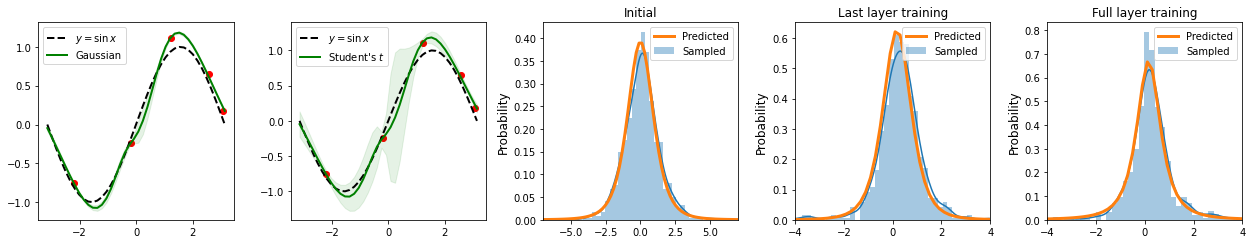

In [71]:
fig, ax = plt.subplots(1, 5, figsize=(17.5, 3.5))
drawer1(ax[0], ax[1])
drawer2(ax[2], 21)
drawer3(ax[3], 20)
drawer4(ax[4], 21)
ax[2].set_xlim(-7, 7)
ax[2].set_ylabel("Probability", fontsize=12)
ax[3].set_xlim(-4, 4)
ax[3].set_title("Last layer training")
ax[4].set_xlim(-4, 4)
ax[4].set_title("Full layer training")
fig.tight_layout()

In [72]:
fig.savefig("corr.pdf")

In [175]:
def draw_sample(
    part,
    train_num = 5,
    test_num = 40,
    alpha = 1.,
    beta = 1.,
    seed = 10,
    noise_scale = 0.1,
    learning_rate = 1e-3,
    ensemble_size = 700,
    train_steps = 10000,
):

    key = random.PRNGKey(seed)
    key, x_key, y_key = random.split(key, 3)

    start, stop = (-np.pi, +np.pi)

    # Dataset
    x_train = random.uniform(x_key, minval=start, maxval=stop, shape=(train_num, 1))
    y_train = target_fn(x_train) + noise_scale * random.normal(y_key, shape=(train_num, 1))

    x_test = jnp.linspace(start, stop, num=test_num)[:, None]

    ensemble_key = random.split(key, ensemble_size)

    if part == "initial":
        network_fn = partial(sample_network, alpha, beta, x_test)
    elif part == "last":
        opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
        opt_update = jit(opt_update)

        network_fn = partial(
            last_train_network, alpha, beta, x_train, y_train, x_test,
            opt_init, opt_update, get_params, train_steps,
        )
    elif part == "full":
        opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
        opt_update = jit(opt_update)

        network_fn = partial(
            full_train_network, alpha, beta, x_train, y_train, x_test,
            opt_init, opt_update, get_params, train_steps,
        )

    samples = vmap(network_fn)(ensemble_key)
    samples = np.squeeze(samples, axis=2).T
    
    # Figure
    def drawer(ax, idx, at, bt, **kwargs):
        sns.distplot(a=samples[idx], ax=ax, label=f"$\\alpha={at}$, $\\beta={bt}$", kde=False, norm_hist=True, hist_kws={"alpha": .85}, **kwargs)
        ax.set_title("Initial")
        ax.set_ylabel("Probability", fontsize=12)
        ax.legend(loc="upper right")

    return drawer

In [178]:
drawer5 = draw_sample("initial", alpha=1/2, beta=1/2)
drawer6 = draw_sample("initial", alpha=2, beta=2)

In [ ]:
drawer7 = draw_sample("last", alpha=1, beta=1)
drawer8 = draw_sample("last", alpha=4, beta=4)

In [ ]:
drawer9 = draw_sample("full", alpha=1/2, beta=1/2)
drawer10 = draw_sample("full", alpha=4, beta=4)

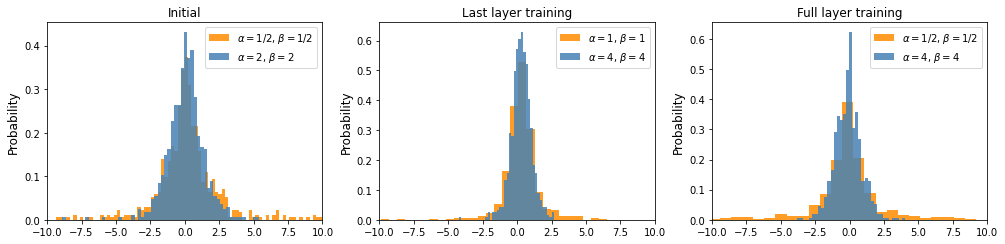

In [209]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3.5))
drawer5(ax[0], 21, "1/2", "1/2", color="darkorange", bins=6000)
drawer6(ax[0], 21, "2", "2", color="steelblue", bins=60)
ax[0].set_xlim(-10, 10)
drawer7(ax[1], 20, "1", "1", color="darkorange", bins=40)
drawer8(ax[1], 20, "4", "4", color="steelblue", bins=40)
ax[1].set_xlim(-10, 10)
drawer9(ax[2], 19, "1/2", "1/2", color="darkorange", bins=35)
drawer10(ax[2], 19, "4", "4", color="steelblue", bins=35)
ax[2].set_xlim(-10, 10)
ax[1].set_title("Last layer training")
ax[2].set_title("Full layer training")
fig.tight_layout()

In [210]:
fig.savefig("corr2.pdf")